# Landscape Ecology and Conservation

**Cristina Banks-Leite, David Orme & Flavia Bellotto-Trigo**

In this practical, we are going to use R to:

1. obtain landscape metrics from a map; 
2. obtain community metrics from a bird dataset; and 
3. analyse the data to assess how Atlantic Forest birds are impacted by habitat
   loss and fragmentation.


```{admonition} Class group exercise
:class: danger
Everyone in the class will have access to the same data but each group will be
assigned a specific question that needs to be answered by Friday 20th November
2020. Instructions for this exercise will be in boxes like this one.

On Friday, one representative from each group (make sure to decide this
beforehand), will present their results on a single slide. A discussion will 
follow.
```

```{admonition} Data exploration exercises
:class: hint
In addition to the instructions for the class exercises, there are some
individual exercises, which ask you to explore the data and techniques used. 
These will be in boxes like this one.
```


## Requirements

This practical needs the following R packages. They have all been installed on
the RStudio Cloud Project for this practical, but if you are following this
practical in R or RStudio installed on your own laptop, you will need to install
the following:

```r
install.packages('raster')
install.packages('sf')
install.packages('landscapemetrics')
install.packages('ggplot2')
install.packages('rgdal')
install.packages('vegan')
```

You can now load the required packages:

In [1]:
library(raster)
library(sf)
library(landscapemetrics)
library(vegan)
library(ggplot2)

Loading required package: sp



Linking to GEOS 3.7.2, GDAL 2.4.2, PROJ 5.2.0



Loading required package: permute



Loading required package: lattice



This is vegan 2.5-6



## Data sets

The first step is to load and explore the datasets.

### Species data

This is a bird data set that was collected in the Brazilian Atlantic Forest
between 2001 and 2007. The data set contains the abundance of 140 species that
were captured in 65 sites, from three different regions, each containing a
control landscape and a 10,000 ha fragmented landscape. The fragmented
landscapes varied in their  proportions of forest cover  (10, 30 and 50% cover).

![](images/figure_sampling_sites.jpg)

More info about the data set can be found in the following papers:

* Banks-Leite, C., Ewers, R. M., & Metzger, J. P. (2012). Unraveling the drivers
  of community dissimilarity and species extinction in fragmented landscapes.
  Ecology 93(12), 2560-2569.
  [https://esajournals.onlinelibrary.wiley.com/doi/10.1890/11-2054.1](https://esajournals.onlinelibrary.wiley.com/doi/10.1890/11-2054.1)

* Banks-Leite, C., Ewers, R. M., Kapos, V., Martensen, A. C., & Metzger, J. P.
  (2011). Comparing species and measures of landscape structure as indicators of
  conservation importance. Journal of Applied Ecology 48(3), 706-714.
  [https://doi.org/10.1111/j.1365-2664.2011.01966.x](https://doi.org/10.1111/j.1365-2664.2011.01966.x)

There are three files to load.

#### Sites data

First, we can load the sites data and use the longitude and latitude coordinates
(WGS84, EPSG code 4326)  to turn the data into an `sf` object.

Classes ‘sf’ and 'data.frame':	65 obs. of  5 variables:
 $ Site        : Factor w/ 65 levels "Alce","Alcides",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Landscape   : Factor w/ 2 levels "Control","Fragmented": 2 2 2 2 1 2 2 2 2 2 ...
 $ Percent     : int  50 30 10 50 90 50 30 50 10 10 ...
 $ Landscape_ID: Factor w/ 3 levels "A","B","C": 2 3 1 2 1 2 3 2 1 1 ...
 $ geometry    :sfc_POINT of length 65; first list element:  'XY' num  -47.5 -23.9
 - attr(*, "sf_column")= chr "geometry"
 - attr(*, "agr")= Factor w/ 3 levels "constant","aggregate",..: NA NA NA NA
  ..- attr(*, "names")= chr  "Site" "Landscape" "Percent" "Landscape_ID"


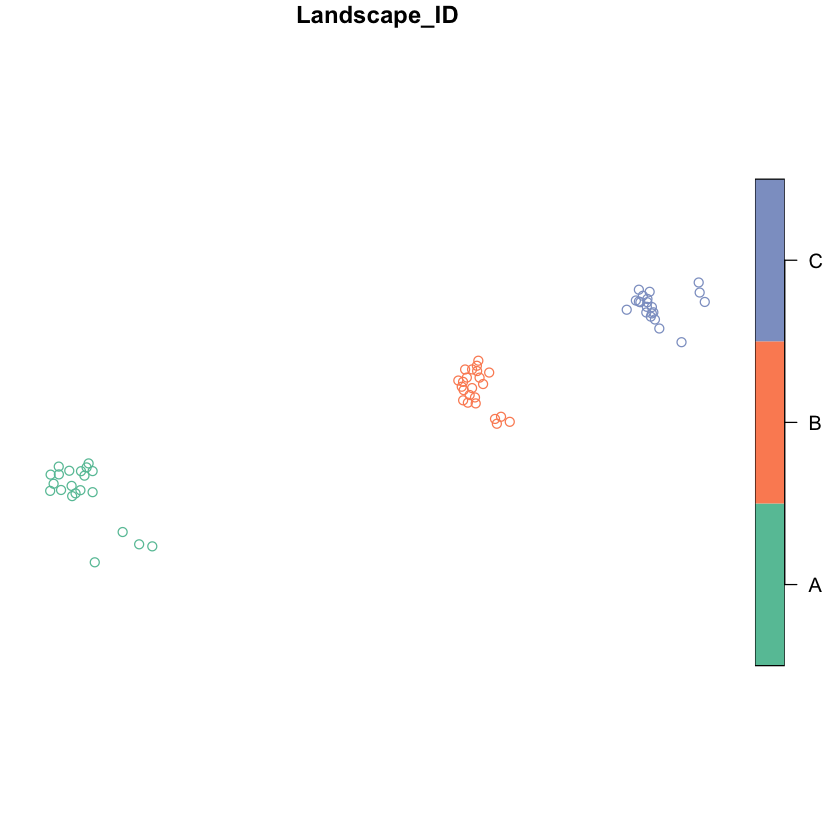

In [2]:
sites <- read.csv("data/sites.csv", header = TRUE)
sites <- st_as_sf(sites, coords=c('Lon','Lat'), crs=4326)
plot(sites[c('Landscape_ID')], key.pos=4)
str(sites)

Region A corresponds to the fragmented landscape with 10% forest cover (and
adjcent control), region B corresponds to fragmented landscape with 50% of cover
(and control) and region C corresponds to  fragmented landscape with 30% of
cover (and control). The `sites` data set describes the characteristics of the
sampling sites: 

* `Landscape`: whether the site belong to a fragmented or a
  continuously-forested control landscape,
* `Percent`: the proportion of forest cover at the 10,000 ha landscape scale,
  and
* `Landscape_ID`: as we just saw, fragmented landscapes were paired with a
  control landscape, so this variable gives you the information of which sites
  belonged to the same region.

#### Abundance data

Next, read in the data set showing the sites x species abundance matrix. As
you'll see, a lot of the species were only caught once or twice and there are
lots of 0s in the matrix. Few species are globally common.

In [3]:
# Load the abundance data and use the first column (site names) as row names
abundance <- read.csv("data/abundance.csv", row.names=1, stringsAsFactors = FALSE)
dim(abundance)

[1]  65 140

The abundance data has 65 rows - one for each site - and there are 140 species
that were seen in at least one site.

#### Species trait data

Last, the bird trait data set includes information about:

*  The main diet of all species, split into five categories (`Invertebrates`,
   `Vertebrates`, `Fruits`, `Nectar`, `Seeds`).
* The preferred foraging strata, split into four categories (`Ground`,
  `Understory`, `Midstory`, `Canopy`)
* The species' mean body size (`BMass`).
* The number of habitats the species uses (`Nhabitats`), representing
  specialisation. 

 The values used for the diet and foraging strata are a semi-quantitative
 measure of use frequency: always (3), frequently (2), rarely (1), never (0).
 This matrix thus contains semi-quantitative variables and continuous variables.

In [4]:
traits <- read.csv("data/bird_traits.csv", stringsAsFactors = FALSE)
str(traits)

'data.frame':	140 obs. of  12 variables:
 $ Species      : chr  "species1" "species2" "species3" "species4" ...
 $ Invertebrates: int  1 1 1 3 3 3 2 3 2 3 ...
 $ Vertebrates  : int  0 0 0 0 0 0 2 0 2 0 ...
 $ Fruits       : int  0 0 0 0 0 0 1 0 1 1 ...
 $ Nectar       : int  3 3 3 0 0 0 0 0 0 0 ...
 $ Seeds        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Ground       : int  0 0 0 1 1 3 1 0 2 0 ...
 $ Understory   : int  3 1 2 3 1 1 2 3 2 3 ...
 $ Midstory     : int  1 2 2 1 3 0 2 1 2 1 ...
 $ Canopy       : int  1 2 2 0 0 0 2 0 0 0 ...
 $ BMass        : num  5 4.3 4.1 18.8 39 24.8 43.4 35.5 175 10.3 ...
 $ Nhabitats    : int  4 3 5 1 1 1 2 1 3 3 ...


#### Data checking

It is always worth looking at the data frames in detail, to understand their
contents. We have used `str` to look at the structure but you can also use
`View` to look at the dataset as a table.

```r
View(sites)
View(abundance)
View(Traits)
```

It is also wise to check for missing data. Some key tools:

```r
summary(abundance) # NAs will be counted if found
any(is.na(abundance))
```

### Landcover data

We will calculate the landscape metrics from a landcover map for the study
region. If you want to know more about the origin of the map, check
[https://mapbiomas.org](https://mapbiomas.org). It is in Portuguese but Google
should translate it for you! This is a database of land cover through time for
the entire country of Brazil - we are using data contemporary with the bird
sampling.

The map is a GEOTIFF file of landcover classes, therefore we are going to use
the function `raster` from the `raster` package to load the map.  First, load
the map and check its coordinate system:

In [5]:
# load map
landcover <- raster("data/map.tif")
print(landcover)

class      : RasterLayer 
dimensions : 7421, 11132, 82610572  (nrow, ncol, ncell)
resolution : 0.0002694946, 0.0002694946  (x, y)
extent     : -49.00004, -46.00003, -24.99993, -23.00002  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : map.tif 
names      : map 
values     : 0, 33  (min, max)



The map has 33 values for the **33 different landcover classes** including:
forest, plantation, mangroves, etc. We will only be looking at forests
(landcover class 3). 

Another important thing is that the map is quite large and  has a **very fine
resolution** (0.000269° is about 1 arcsecond or ~30 metres). There are over 82
million pixels in the image and so the data is slow to handle. In fact, although
the file loaded quickly, it **did not load the actual data**. The `raster`
package often does this to keep the memory load low - it only loads data when
requested and has tricks for only loading the data it needs. You can see this:

In [6]:
inMemory(landcover)

[1] FALSE

We're not even going to try and plot this map! This is something that would be
much easier to view in QGIS, which handles visualising big data well. We will
extract some data from it in the next section.

## Calculating landscape metrics

### Landscape data processing

Before we calculate landscape metrics, we first need to process the land cover
data to make it easier to work with. In particular, using the whole map is very
computationally demanding so we need to reduce the data down to the scale of the
focal regions to extract landscape metrics for each site. In order to do that we
need to:

1. Identify a smaller region of interest for the sites
2. Crop the landcover raster down to this region, to use a small dataset.
3. Convert the landcover to a binary forest - matrix map.
4. Reproject the data into a suitable projected coordinate system.

In [7]:
# Get the bounding box and convert to a polygon
sites_region <- st_as_sfc(st_bbox(sites))

# Buffer the region by 0.1 degrees to get coverage around the landscape.
# This is roughly 10 kilometres which is a wide enough border to allow
# us to test the scale of effects.
# - this throws out a warning, but this is only a rough border.
sites_region <- st_buffer(sites_region, 0.1)

# Convert to a `sp` extent object for use in `crop`
sites_extent <- extent(matrix(st_bbox(sites_region), ncol=2))

# Crop the landcover data and convert to a binary forest map
sites_landcover <- crop(landcover, sites_extent)
sites_forest <- sites_landcover == 3
print(sites_forest)

class      : RasterLayer 
dimensions : 2188, 5407, 11830516  (nrow, ncol, ncell)
resolution : 0.0002694946, 0.0002694946  (x, y)
extent     : -48.3988, -46.94164, -24.25424, -23.66459  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : memory
names      : layer 
values     : 0, 1  (min, max)



If you check that final output, you will see that the values changed to `values:
0, 1 (min, max)`.

Now that we have the regional forest for the sites, we can reproject the data.
We will use UTM Zone 23S (EPSG: 32723) for all of the landscapes. Remember that
the landcover class data is categorical - we *have* to use `method='ngb'` when
projecting the data. We've also set a resolution of 30 metres. The original 
WGS84 pixels are not square in UTM23S because 1 arc second NS is not equal to
1 arc second EW, and so setting the resolution tells `projectRaster` to use that
fixed size rather letting it create rectangular pixels.

In [8]:
sites_utm23S <- st_transform(sites, 32723)
# This takes a little while to run!
sites_forest_utm23S <- projectRaster(sites_forest, crs="+init=epsg:32723", 
                                     res=30, method='ngb')

Just to check, we should now be able to plot the sites and forest.

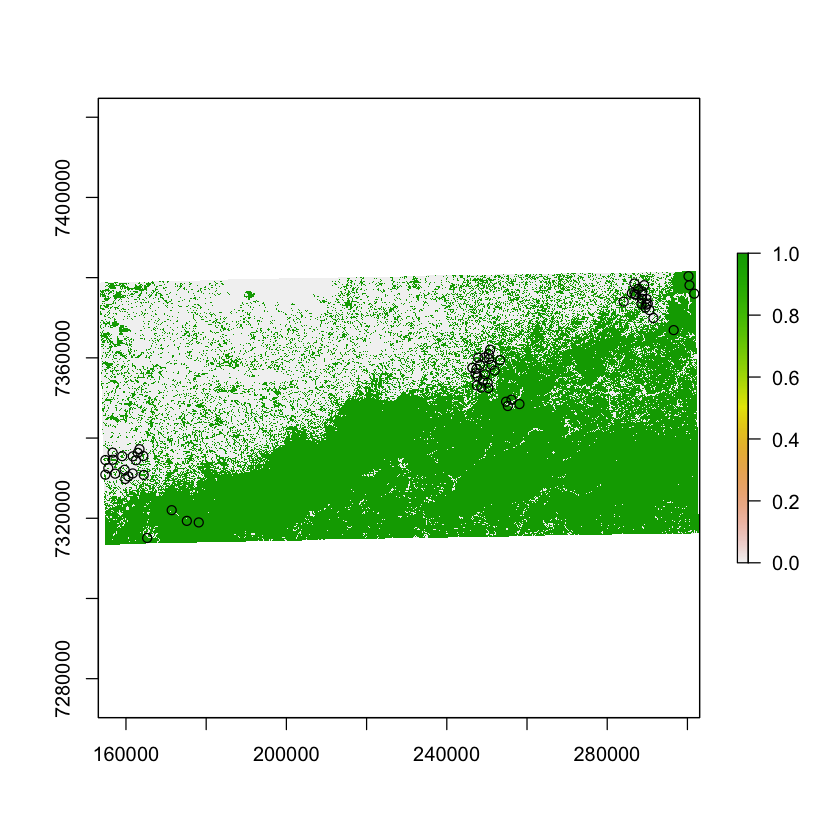

In [9]:
plot(sites_forest_utm23S)
plot(st_geometry(sites_utm23S), add=TRUE)

### Extracting landscape metrics

You can now explore the functions in the package
[`landscapemetrics`](https://cran.r-project.org/web/packages/landscapemetrics/landscapemetrics.pdf)
to measure different landscape metrics. You can also look at the complete set of
**132** landscape metrics that the package will calculate:

In [10]:
lsm_abbreviations_names

metric,name,type,level,function_name
<chr>,<chr>,<chr>,<chr>,<chr>
area,patch area,area and edge metric,patch,lsm_p_area
cai,core area index,core area metric,patch,lsm_p_cai
circle,related circumscribing circle,shape metric,patch,lsm_p_circle
contig,contiguity index,shape metric,patch,lsm_p_contig
core,core area,core area metric,patch,lsm_p_core
enn,euclidean nearest neighbor distance,aggregation metric,patch,lsm_p_enn
frac,fractal dimension index,shape metric,patch,lsm_p_frac
gyrate,radius of gyration,area and edge metric,patch,lsm_p_gyrate
ncore,number of core areas,core area metric,patch,lsm_p_ncore


#### Landscape levels 

There are three core levels of calculation and it is important to understand how
these are applied within a local landscape:

* The **patch** level metrics are things that are calculated for every single
  patch in the local landscape. So in the output, there is one row for each
  patch and it is identified with a patch `id` and a `class` id.
* The **class** level metrics are aggregated across all patches of a specific
  class, so there is a row for each class that appears in the local landscape,
  labelled with a `class` id (but no patch).
* The **landscape** metrics aggregate *all* patches, so there is just one row
  per landscape.

To show how these values are reported - and how we can use them - the following
code uses the `sample_lsm` function to calculate a set of metrics for patch
counts and areas at all three levels, along with the proportion landcover of
each class. The local landscape is defined as a circle with a radius of 600
meters. We will use the Alce site as an example:

In [11]:
# Calculate patch areas at patch, class and landscape scale.
lsm <- sample_lsm(sites_forest_utm23S, sites_utm23S, 
                  shape = "circle", size = 600, 
                  plot_id = sites_utm23S$Site, 
                  what = c('lsm_p_area',
                           'lsm_c_np', 'lsm_l_np', 
                           'lsm_c_area_mn', 'lsm_l_area_mn',
                           'lsm_c_pland'))

# Use Alce as an example
alce <- subset(lsm, plot_id=='Alce')
print(alce, n=22)

Warning message:
“The 'perecentage_inside' is below 90% for at least one buffer.”


# A tibble: 23 × 8
   layer level     class    id metric  value plot_id percentage_inside
   <int> <chr>     <int> <int> <chr>   <dbl> <fct>               <dbl>
 1     1 class         0    NA area_mn 19.0  Alce                 99.9
 2     1 class         1    NA area_mn  3.35 Alce                 99.9
 3     1 class         0    NA np       4    Alce                 99.9
 4     1 class         1    NA np      11    Alce                 99.9
 5     1 class         0    NA pland   67.3  Alce                 99.9
 6     1 class         1    NA pland   32.7  Alce                 99.9
 7     1 landscape    NA    NA area_mn  7.52 Alce                 99.9
 8     1 landscape    NA    NA np      15    Alce                 99.9
 9     1 patch         0     1 area    74.9  Alce                 99.9
10     1 patch         0     2 area     0.09 Alce                 99.9
11     1 patch         0     3 area     0.09 Alce                 99.9
12     1 patch         0     4 area     0.9  Alce         

In [12]:
# Calculate total area
sum(alce$value[alce$metric == 'area'])

[1] 112.86

From that table, you can see that there are 14 patches in the Alce local
landscape that sum to 113.13 hectares. That is not quite the precise area of the
circular landscape ($\pi \times 600^2 = 1130973 m^2 \approx 113.1 ha$) because
the landscape is used to select a set of whole pixels. The `class` metrics
summarise the areas of the patches by class (10 forest patches, 4 matrix
patches) and the `landscape` metrics aggregate everything. We can use the table
to calculate the `lsm_l_area_mn` value by hand:

In [13]:
# Weighted average of class patch sizes (with some rounding error)
(19.1 * 4 + 3.65 * 10) / 14

[1] 8.064286

#### Merging landscape metrics onto sites

The contents of `lsm` is rather unhelpful in two ways:

1. The variables are not in separate columns, but stacked in the `value` and
   `metric` fields. 
2. Class variables include rows for both the matrix and forest, and we are
   primarily interested in the forest class metrics.

So, we need a couple of tools to help convert this output into something easier
to use:

1. We can use `subset` to keep just the columns and rows we actually want:
   forest class metrics and values. 
2. We need to `reshape` the data frame to have a column for each measure. (The
   help and syntax of the `reshape` function is *notoriously* unhelpful - there
   are other, better tools but this simple recipe works here).
3. Along the way, we should make sure that our variable names are clear - we
   want the method of calculation of each value to be obvious.

In [14]:
# Drop the patch data and landscape rows
lsm_forest <- subset(lsm, level == 'class')
# Drop down to the forest class and also reduce to the three core fields
lsm_forest <- subset(lsm_forest, class == 1, select=c(metric, value, plot_id))

# Rename the value field so that - when combined with the metric
# name - the local landscape details are recorded
names(lsm_forest)[2] <- 'C600'

# Reshape that dataset so that each metric has its own column
lsm_forest <- reshape(data.frame(lsm_forest), direction='wide', 
                      timevar='metric', idvar='plot_id')
head(lsm_forest, n=10)

,plot_id,C600.area_mn,C600.np,C600.pland
,<fct>,<dbl>,<dbl>,<dbl>
1,Alce,3.354545,11,32.69537
4,Alcides,4.910000,9,38.93735
7,Alteres,28.620000,1,25.27822
10,Antenor,95.670000,1,84.76874
13,Areial,112.770000,1,100.00000
16,Baleia,7.087500,8,50.19920
19,BetoJamil,4.880000,9,38.60759
22,Bicudinho,11.250000,4,39.74563
25,Boiadeiro,4.590000,4,16.25498


Now it is easy to match those landscape metrics to the `sites` data.

In [15]:
sites <- merge(sites, lsm_forest, by.x='Site', by.y='plot_id')

```{admonition} Group exercise
:class: danger
This exercise will consist of obtaining a number of landscape metrics for each
of our 65 sites, so we can later use them as explanatory variables in a model to
understand how birds are affected by habitat loss and fragmentation. 

Each group will focus on a set of metrics that capture different aspects of
landscape structure.  Look up and read the information for your metrics, so you
can have a better understanding of what they mean, and collate them all to the
`sites.csv` spreadsheet (or you can create another spreadsheet). You may need to
defend your choice of landscape metric on the presentation!

In all cases, we are interested in the **forest specific values of the `class`
metrics**, so you will need to subset and reshape the data as above. There is a
help page for each metric: for example, `?lsm_c_area_cv`.

* **Groups SP01, SP02, SP03**: Patch size & number of patches
  * Coefficient of variation of patch area (`lsm_c_area_cv`)
  * Mean of patch area (`lsm_c_area_mn`)
  * Number of patches  (`lsm_c_np`) 
* **Groups SP04, SP05, SP06**: Connectivity
  * Patch density (`lsm_c_pd`)
  * Coefficient of variation of euclidean nearest-neighbor distance (`lsm_c_enn_cv`)
  * Aggregation index (`lsm_c_ai`)
* **Groups SP07, SP08, SP09**: Edge effects
  * Coefficient of variation perimeter-area ratio (`lsm_c_para_cv`)
  * Coefficient of variation of related circumscribing circle (`lsm_c_circle_cv`)
  * Edge density (`lsm_c_ed`)
* **Groups SP13, SP14**: Forest cover
  * There is only one way to measure habitat cover: `lsm_c_pland`. These groups
    will also focus on exploring the *scale of effect*: the spatial scale at
    which responses are strongest. You'll need to calculate forest cover using
    radii of 300, 500, 800, 1100 and 1400 m. Note that `lsm_c_pland` is a
    proportion of the area, so does not need to be adjusted for the changing
    landscape area.

```

## Calculating biodiversity metrics

The over-riding research question we are looking at is:

> Is the structure of the bird community influenced by the spatial
> characteristics of the sites?

However there are lots of different ways of measuring community structure. We
will look at measures of overall diversity, community composition and functional
diversity.

### Measuring site abundance, species richness, species diversity and evenness 

Abundance can be measured at the species level, but here we are interested in
total community abundance, so the total number of individuals captured at each
site. We can only measure bird abundance because this study used mist nets,
where each individual was uniquely tagged.  

To measure species richness you can use the function `specnumber` from the
`vegan` package. As we saw in the lecture, **Measuring Biodiversity**, sometimes
you may need to control for sampling effort or number of individuals to compare
species richness across sites. You can use rarefaction (with function `rarefy`)
to estimate how many species you would have seen if you had lower sampling
effort or fewer individuals.  If you're interested in understanding how species
diversity changes, you can measure the Shannon index ($H$) by using the function
`diversity`. The **vegan** package doesn't have any functions for measuring
evenness, but Pielou's Evenness ($J$) is easily measured with the formula below:

In [16]:
# First, we sort the rows of abundance to make sure that they are in the
# same order as the sites data frame.
site_order <- match(rownames(abundance), sites$Site)
abundance <- abundance[site_order, ]

# Now we can store diversity metrics values in the sites data frame
sites$total_abundance <- rowSums(abundance)
sites$richness <- specnumber(abundance)
sites$Srar <- rarefy(abundance, min(sites$total_abundance))
sites$H <- diversity(abundance, index='shannon')
# Pielou's evenness
sites$J <- sites$H / log(sites$richness)

```{admonition} Exploring the data
:class: hint
What is the correlation between richness, diversity, evenness and abundance
across sites? You can use the function `cor()` and `plot()` the results to
better understand the patterns. Which biodiversity metrics would you choose to
report your results and why?
```

In [17]:
# Some example code to modify:
cor(sites$richness, sites$total_abundance)

[1] 0.6451641

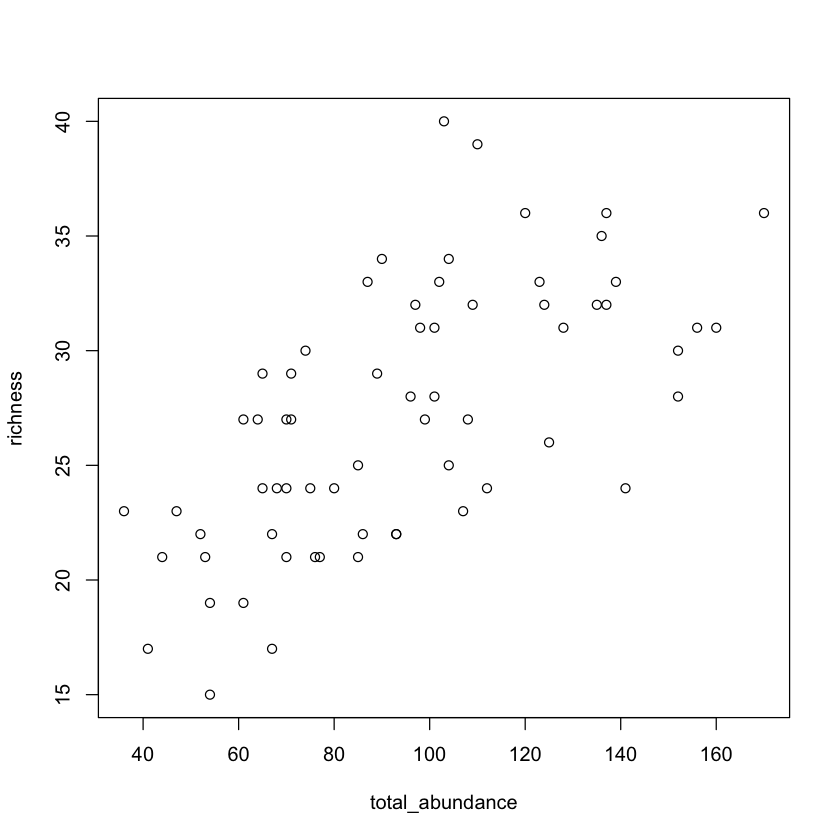

In [18]:
plot(richness ~ total_abundance, data=sites)

Hint: There is no right or wrong answer here. You can choose any metric as long
as you understand its advantages and disadvantages.


#### Species abundance distribution

We could also look at the rank abundance of species to understand if our
community is dominated by a few species or to assess the prevalence of rare
species. Rare species are those that were caught a few times only. This is
*very* arbitrary and likely to be biased by how easily species are disturbed and
trapped.

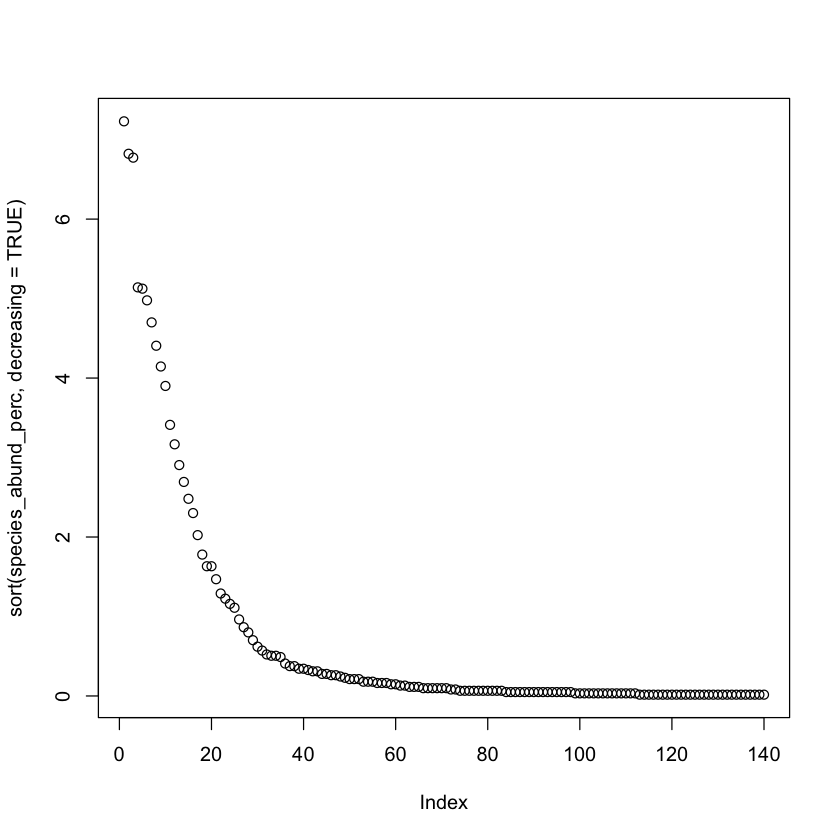

In [19]:
# Get the total abundance of each _species_
species_abund <- colSums(abundance)
# Transform into relative percent abundance
species_abund_perc <- species_abund / sum(species_abund) * 100
# Plot from most to least abundant
plot(sort(species_abund_perc, decreasing = TRUE))

How does this compare to slide 11 of **Measuring Biodiversity** lecture which
shows the patterns of Amazonian trees and bats? Try doing this for each
fragmented landscape to see if trends are affected by habitat cover.

### Measuring community composition

Community composition is a class of biodiversity measure that incorporates
information on species richness, abundance and species identity. That
inclusivity makes them a very informative biodiversity metric but they are also
complex to compute and interpret. 

There are three stages to assessing community composition:

1. The raw data for community composition is a site by species matrix showing
   the abundance (or presence) of each species at each site. It is common to
   **transform the site by species** data in one or more ways to adjust the
   emphasis given to the different species before assessing composition.

2. The site by species matrix is then transformed into a **dissimilarity
   matrix** - a site by site matrix that quantifies the differences between the
   communities at each pair of sites.

2. The dissimilarity matrix represents a complex pattern of community
   differences and an **ordination** can then be used to identify independent
   axes of community variation across sites. 

All of these steps have multiple options!

#### Transforming site by species data.

There are several common approaches used for transforming site by species
matrices *before* calculating dissimilarities. All of these approaches alter the
weighting given to the different species.

1. Reducing abundance data to a **binary presence-absence data**. This
   transformation emphasizes differences in species identity and differences in
   rare species between sites, often giving measures of $\beta$ diversity, and
   is also often used when sampling is not thought to give reliable abundance
   data. The `vegdist` function (see below) has the option (`binary=TRUE`) to do
   this automatically.

2. **Scaling abundance data**.  Variation in the abundance data can be driven by
   a few common species, particularly when the variation in abundance of some
   species is much larger than others (e.g. one species varies in abundance from
   0 to 1000, and all other species vary from 0 to 10). In our case, the most
   abundant species only varied from 0 to 24 individuals, so scaling this
   dataset should  not particularly affect the results. Scaling a dataset alters
   the balance of the analysis to equally weight each species when calculating
   dissimilarity which *can* provide more biologically meaningful results. 

3. Although this seems counterintuitive, the detectability and distribution of
   rare species can confound community patterns among the common species.
   **Removing rare species** can therefore help make major compositional shifts
   more obvious. This is particularly important in microbiome studies with
   thousands of OTUs (e.g. it is common in these studies to exclude the 5% least
   common OTUs). 

We will revisit this but for the moment we will stick with the raw abundance
data.

#### Calculating dissimilarity Indices 

Dissimilarity indices are used to compare two sites using the total number (or
abundances) of species in each site (A + B), along with the number (or
abundances) of species shared between the site (J). These can be calculated
using the `vegdist` function in `vegan`. A large number of indices have been
proposed and can be calculated in `vegan`: look at the help for both `?vegdist`
and `?designdist` for the details!


We have many options but we have to start somewhere: we will use the
[Bray-Curtis](https://en.wikipedia.org/wiki/Bray%E2%80%93Curtis_dissimilarity)
dissimilarity index computed from raw abundances.

In [20]:
bray  <- vegdist(abundance, method="bray", binary=FALSE)

Have a look at the association matrix (`print(bray)`), and notice it is
triangular. Why do you think that is? We can visualise this data to help
understand what is going on. We're actually going to cheat a bit here - we have
a big matrix and the `raster` package is really good at plotting those
quickly...

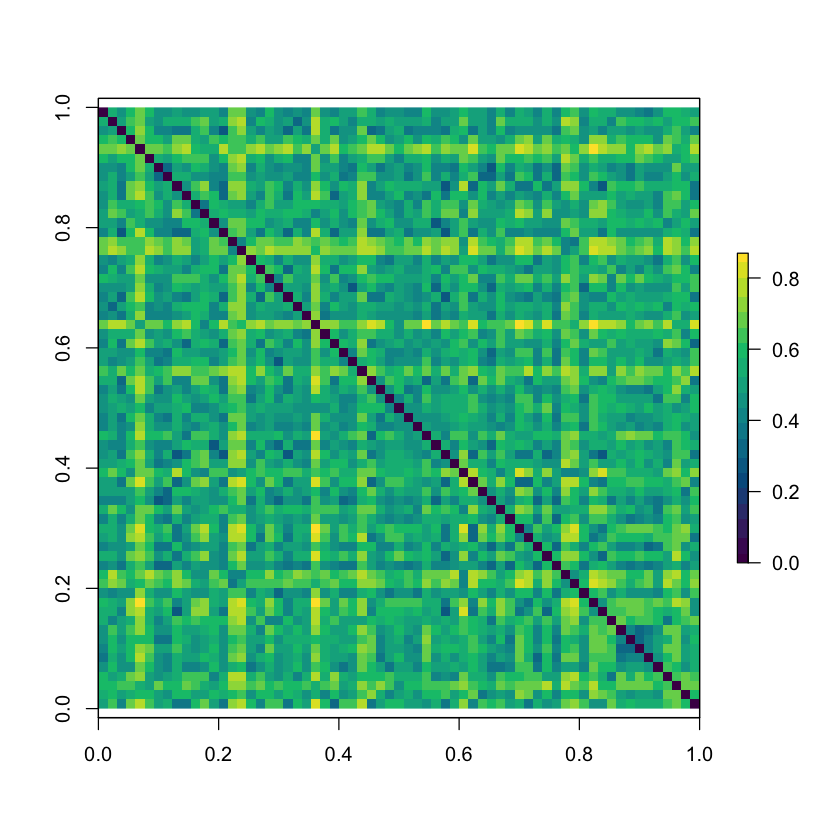

In [21]:
bray_r <- raster(as.matrix(bray))
plot(bray_r, col=hcl.colors(20))

The first thing that jumps out is the diagonal - this is just that comparing a
site to itself gives zero dissimilarity. All of the other pairwise combinations
show a range of values.

If we want to compute the dissimilarity matrix based on another index, we can
simply change `method="bray"` to any of the other indices provided in `vegdist`.
Each dissimilarity metric has advantages and disadvantages but Bray-Curtis and
Jaccard are commonly used for species abundance data. 

Note that some of these indices in `vegdist` are not appropriate for abundance
data. For example, Euclidean distance is widely used for environmental data
(landscape metrics, geographic distance, temperature, altitude, etc) but is
**not** ecologically meaningful for biodiversity data!    


#### Principal coordinate analysis

We can now perform a principal coordinate analysis (PCoA) using the `bray`
matrix as input. This is sometimes called *classical multidimensional scaling*,
hence the function name: `cmdscale`. The PCoA will take your dissimilarity
matrix and represent the structure in this dataset in a set of independent
vectors (or ordination axes) to highlight main ecological trends and reduce
noise. You can then use ordination axes to represent how similar (or dissimilar)
two sites are with respect to the species they have. 

Do not confuse *classical multidimensional scaling* with *non-metric
multidimensional scaling* (NMDS), which is also very popular!

In [22]:
pcoa <- cmdscale(bray, k=8, eig=TRUE)

A PCoA calculates multiple independent axes of variation in the community
dissimilarity. In fact, it calculates as many axes are there are sites. However,
these **different axes differ in how much variation they describe** - we rarely
want to consider more than a few. Here, we have only kept the data for the first
eight (`k=8`). We are also hanging on the eigenvalues (`eig=TRUE`), which are
measures of the amount variation associated with each axis.

##### Community separation in space

We will now explore community composition graphically, which is most convenient
in two dimensions. We have to extract the new coordinates of the data before
being able to plot them. Once again, it is wise to give clear names to each
variable, otherwise we end up with variable names like `X1`.

In [23]:
# Extract the scores 
pcoa_axes <- pcoa$points
colnames(pcoa_axes) <- paste0('bray_raw_pcoa_', 1:8)

We can look at the correlations between all of those axes. We are using
`zapsmall` to hide all correlations smaller than $10^{-10}$ - as expected, none
of these axes are correlated.

In [24]:
zapsmall(cor(pcoa_axes), digits=10)

,bray_raw_pcoa_1,bray_raw_pcoa_2,bray_raw_pcoa_3,bray_raw_pcoa_4,bray_raw_pcoa_5,bray_raw_pcoa_6,bray_raw_pcoa_7,bray_raw_pcoa_8
bray_raw_pcoa_1,1,0,0,0,0,0,0,0
bray_raw_pcoa_2,0,1,0,0,0,0,0,0
bray_raw_pcoa_3,0,0,1,0,0,0,0,0
bray_raw_pcoa_4,0,0,0,1,0,0,0,0
bray_raw_pcoa_5,0,0,0,0,1,0,0,0
bray_raw_pcoa_6,0,0,0,0,0,1,0,0
bray_raw_pcoa_7,0,0,0,0,0,0,1,0
bray_raw_pcoa_8,0,0,0,0,0,0,0,1


Now we can merge them onto the site data to make sure that the landscape and
community metrics are matched by site.

In [25]:
# Convert the pcoa axis values to a data frame and label by site
pcoa_axes_df <- data.frame(pcoa_axes)
pcoa_axes_df$Site <- rownames(pcoa_axes)
# Merge onto the sites data - the PCoA axes get the labels X1 to X8
sites <- merge(sites, pcoa_axes_df, by='Site')

Now we can look to see how the community metrics reflect the landscape
structure.

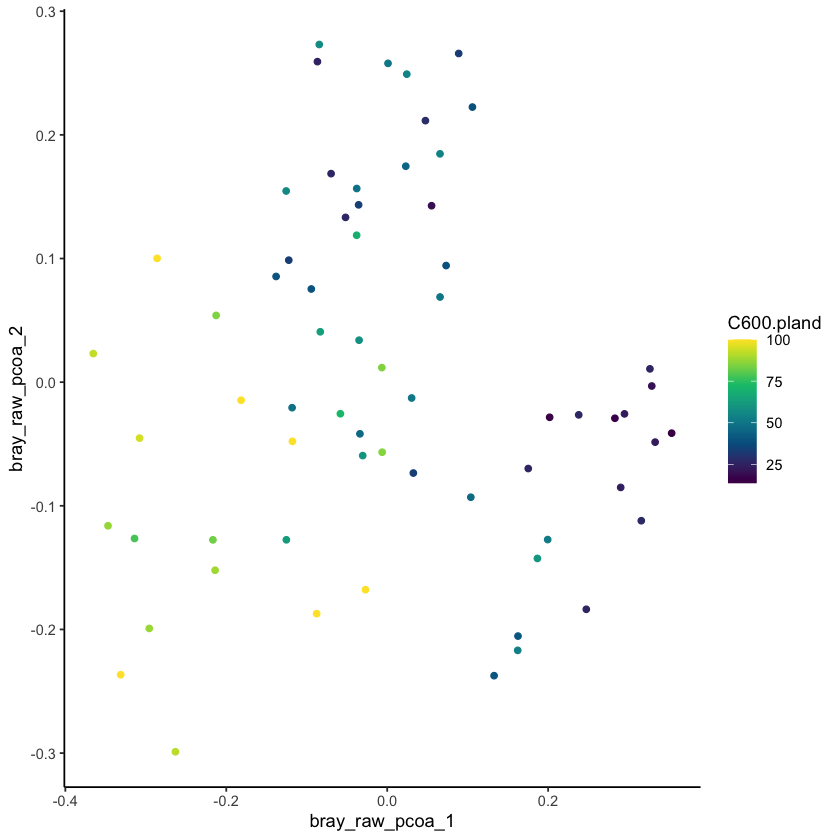

In [26]:
ggplot(sites, aes(bray_raw_pcoa_1, bray_raw_pcoa_2)) +
  geom_point(aes(colour = C600.pland)) + 
  scale_colour_gradientn(colors=hcl.colors(20)) + 
  theme_classic() 

Which patterns can you see from that plot? Along which axis do you see the
trends varying the most, PCoA1 or PCoA2? Try looking at some of the other PCoA
axes.

```{admonition} Exploring the data
:class: hint
Now plot PCoA axis 1 against the percentage of forest cover. Which trends do you get?
And what about axis 2? 
```

##### How many axes to consider

The eigenvalues show the variance - hence the information content - associated
with each principal coordinate axis. Note that the eigenvalues are in descending
order, so that the axes are numbered in order of their importance. Also note
that some of the eigenvalues are negative - these axes cannot be interpreted
biologically, but luckily this is never a problem for the first few axes which
are the most meaningful anyway.

To make it easier to decide on how many dimensions we will keep, we look at the
proportion of the total variance in the data set that is explained by each of
the principal coordinates. The cumulative sum of eigenvalues describes how much
of the variation in the original data is explained by the first *n* principal
coordinates. We will drop the negative eigenvalues - they just confuse the
cumulative calculation!

[1] "21.16%" "12.04%" "8.85%"  "5.86%"  "4.92%"  "3.94%"  "3.68%"  "3.42%"

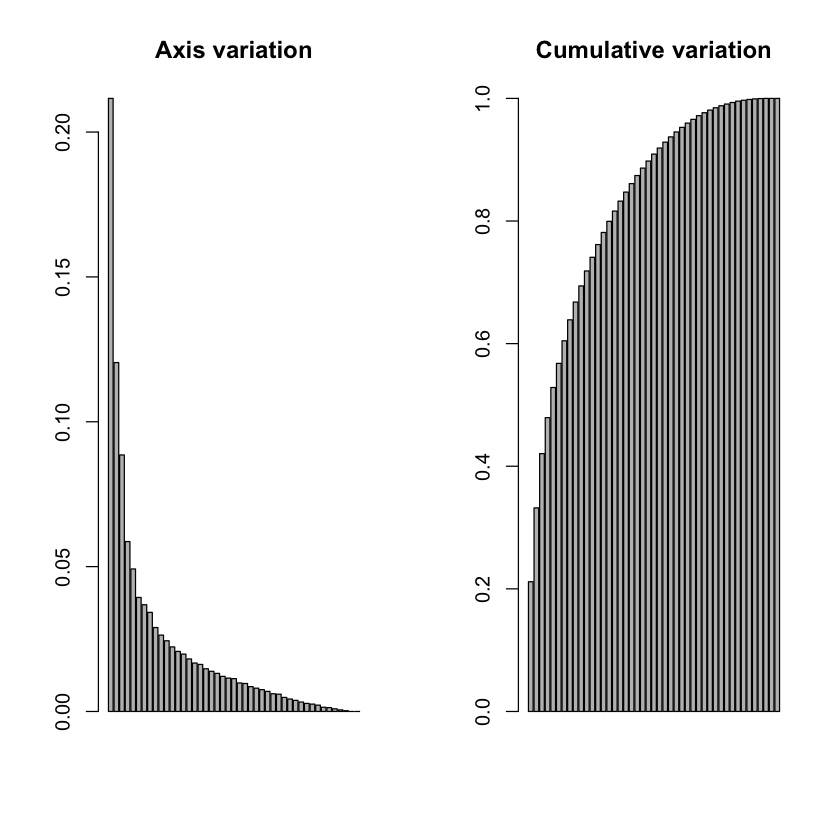

In [27]:
par(mfrow=c(1,2))
eig <- pcoa$eig[pcoa$eig >0] 
barplot(eig / sum(eig), main='Axis variation')
barplot(cumsum(eig)/ sum(eig), main='Cumulative variation')
# Print the percentage variation of the first 8 
head(sprintf('%0.2f%%', (eig / sum(eig)) * 100), n=8)

For this particular PCoA, the bar plot doesn't really give a good indication
about the number of principal coordinates axes to retain: the bars gradually
decrease in size rather than showing a clear cutoff.  From those plots, we can
see that the first principal coordinate axis contains almost twice as much
information as the second one (21.2% versus 12.0%). However, together they still
only explain 33.2% of the variation. 

However we shouldn't blindly look at percentages. For instance, if one species
in the matrix varies from 0 to 1,000 individuals - while all the other species
vary from 0 to 10 - the percentage of information captured by the first axis will
be considerably larger, but the axis will be only representing the variation in
that particularly abundant species. If a *scale* function is applied to this
hypothetical dataset, the percentage of information captured by the first axis
will dramatically reduce, but this axis will provide more biologically
meaningful results (i.e., it will better represent variation in the other
species). Furthermore, the proportion of variation explained by the first axis
reduces as -in this case- the number of species increases, so the amount of
variation explained by the first axis is reasonable given that we have 140
species!


<!-- Hidden to reduce handout complexity

````{admonition}  Sidebar: Shepard diagrams
:class: hint
Shepard diagram's compares the distances between sites using our PCoA axes to
the original distances calculated using all the community data. If the PCoA
captures the data well, these two distances will be strongly correlated and so
these are a useful tool to see if a community analysis is capturing the
community structure well. However, remember that one of the *points* of using an
ordination is to remove complexity and noise, so the point of a Shepard diagram
is to make sure the ordination is working as expected and *not* to try and get a
perfect correlation with the raw data.

We will use Euclidean distances between sites in the PCoA ordination space. This
will provide us with a matrix of distances between objects that can be directly
compared to the original distance between objects computed from a Bray-Curtis
dissimilarity index. We can compare the Shepard diagram when using all 8 of the
axes we kept, to simply using the first two axes:

```{code-cell} R
# Use first 8 axes
shepard_8  <- vegdist(pcoa_axes, method="euc", binary=FALSE)
# Use just the first 2
shepard_2  <- vegdist(pcoa_axes[, c(1,2)], method="euc", binary=FALSE)
```

Now let's plot this against the Bray-Curtis distances.

```{code-cell} R
par(mfrow=c(1,2))
plot(shepard_8, bray, main='First 8 axes')
plot(shepard_2, bray, main='First 2 axes')
```

The correlation is clearly stronger with all eight axes but both look pretty
good. But can we improve it? And can we make do with just one axis?

````
-->


```{admonition} Explore the data - community metric variations.
:class: hint
All of the information from that PCoA depends entirely on our choices for the
original dissimilarity  matrix. If we change that metric then the *positions of
sites in the ordination space will change* and so will *the relative importances
of the PCoA axes*.

So, now explore varying the steps in this analysis. Change your inputs, change
the dissimilarity metric and recalculate your ordination.

1. Use the command `scaled_abundance <- scale(abundance)` and use this as an
input to `vegdist`. This will automatically scale the matrix by columns, so
each column will have a mean of near 0, and standard deviation of 1. 

2. Use presence-absence data by using the argument `binary =TRUE` with
   `vegdist`. 

3. Try excluding the rare species (e.g. all species with 5 or less individuals):

    ```R
    # choose columns (species) from abundance where total abundance is greater than 5
    total_abundance <- colSums(abundance)
    common <- abundance[,which(total_abundance > 5)]
    # data only has 71 columns now
    str(common)
    ```

4. Try using at least another dissimilarity metric.

Do any of these options seem to give a clearer relationship between the
community composition and forest cover? There is no right or wrong answer here -
different choices reflect different hypotheses.

```

```{admonition} Regression of landscape and community metrics
:class: hint
In addition to looking at correlations, we can fit linear models to predict how
community composition varies between fragmented landscapes and continuous
landscapes? 

From the model below, forest cover at the 600m landscape scale explains 56.3% of the
variation in community composition. Hence, we see that the first principal
coordinate can reveal interesting biological trends, even if it only contained
21.2% of the information in the original data set (see above).
```


Call:
lm(formula = bray_raw_pcoa_1 ~ C600.pland, data = sites)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.242281 -0.081431 -0.006381  0.093915  0.222799 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.2866914  0.0347933   8.240 1.36e-11 ***
C600.pland  -0.0053646  0.0005829  -9.203 2.89e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1249 on 63 degrees of freedom
Multiple R-squared:  0.5734,	Adjusted R-squared:  0.5667 
F-statistic: 84.69 on 1 and 63 DF,  p-value: 2.89e-13


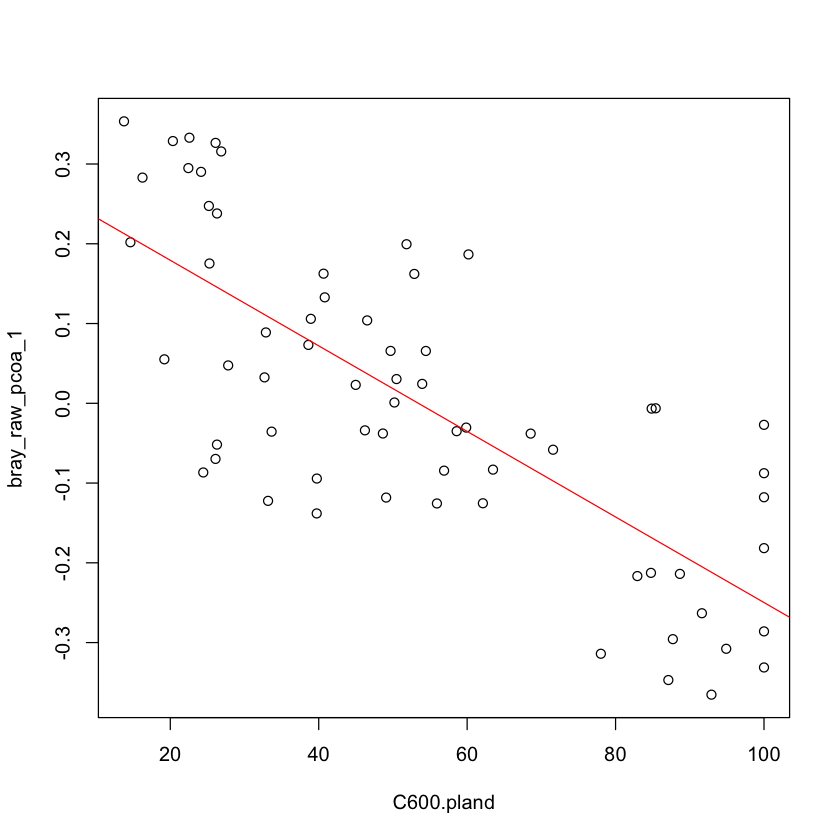

In [28]:
# Model community composition as a function of forest cover
mod_fc <- lm(bray_raw_pcoa_1 ~ C600.pland, data=sites)
summary(mod_fc)
# Plot the model
plot(bray_raw_pcoa_1 ~ C600.pland, data=sites)
abline(mod_fc, col='red')

### Functional diversity

There are many measures of functional diversity, evenness and composition. Here
we will only use one approach `treedive`, which is available in the `vegan`
package. This calculates functional diversity as the total branch length of a
trait dendrogram. The higher the number the more variation we have in traits
within a community, which in theory equals to more functions provided.

> Petchey, O.L. and Gaston, K.J. 2006. Functional diversity: back to basics and
> looking forward. Ecology Letters 9, 741–758.

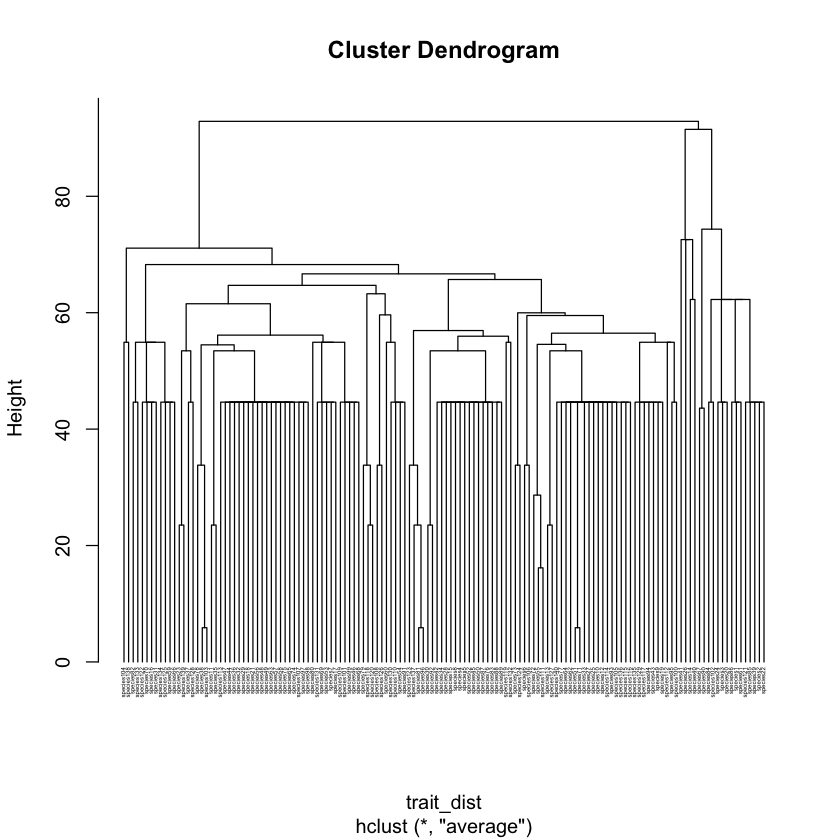

In [29]:
# Get a data frame holding only trait values, with rownames 
traits_only <- subset(traits, select=-Species)
rownames(traits_only) <- traits$Species
# Calculate the trait distance matrix
trait_dist <- taxa2dist(traits_only, varstep=TRUE)
# And get a trait dendrogram
trait_tree <- hclust(trait_dist, "aver")
plot(trait_tree, hang=-1, cex=0.3)

That dendrogram shows how species are clustered according to their trait
similarity and the branch lengths measure an amount of functional diversity. The
next step is to find the set of species in each site, reduce the dendrogram to
just those species and find out the total branch length of that subtree.

In [30]:
trait_diversity <- treedive(abundance, trait_tree)

forced matching of 'tree' labels and 'comm' names



Now we just need to bring that data into our `sites` dataset to be able to use
it.

In [31]:
trait_diversity <- data.frame(Site=names(trait_diversity),
                              trait_diversity=trait_diversity)
sites <- merge(sites, trait_diversity)

```{admonition} Explore the data
:class: hint
How does functional diversity vary with percentage of forest cover across sites?

```

```{admonition} Group exercise
:class: danger

Each group already have their landscape metrics measured, now you will need to
focus on choosing one response variable that best represents variation in your
data. Choose it carefully because you will need to defend your choice when you
present your results.


* **Groups SP01, SP04, SP07, SP13**: Species richness and abundance

We have explored different ways to measure abundance, richness, diversity,
evenness. Select one of these  as your response variable.

* **Groups SP02, SP05, SP08, SP14**: Community composition

We have explored different ways to do an ordination. You can scale or not, use
binary data or not, your choice. Select one of these as your response variable.

* **Groups SP03, SP06, SP09**: Functional diversity

We only explored one way of measuring functional diversity. But there are other
more traditional ways of looking into traits of species that we have, for
instance, species richness of insectivores, or abundance of specialists (those
that only use one habitat). You have freedom to choose the response variable of
preference. 

```

## Presenting your results on Friday 20th November.

Please have one slide ready to present with the graph of your response ~
exploratory variable. Please ensure that the labels can be read on small
screens. Also, please include on this graph a fitted line, and ideally a
confidence interval. The slide should also contain the $r^2$ of the relationship
and p-value. Do not worry if you don't find significant results! That's to be
expected. Each group will have a maximum of 5 minutes to present their results.


A final note on analyses: some of the variables we have used are better modelled
using a GLM. That has not yet been covered in depth in the Masters modules. You
are not expected to use a GLM here - although you can if you know how to use it
and a GLM would be appropriate for your data. 

It is anticipated that the exploratory variables **will** be correlated, so
fitting more complex models (e.g. a multiple regression) may not be appropriate.
This is the same problem of **multicollinearity** that was mentioned in the GIS
week. For the moment, use single regressions for each exploratory variable at a
time.